## Data understanding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

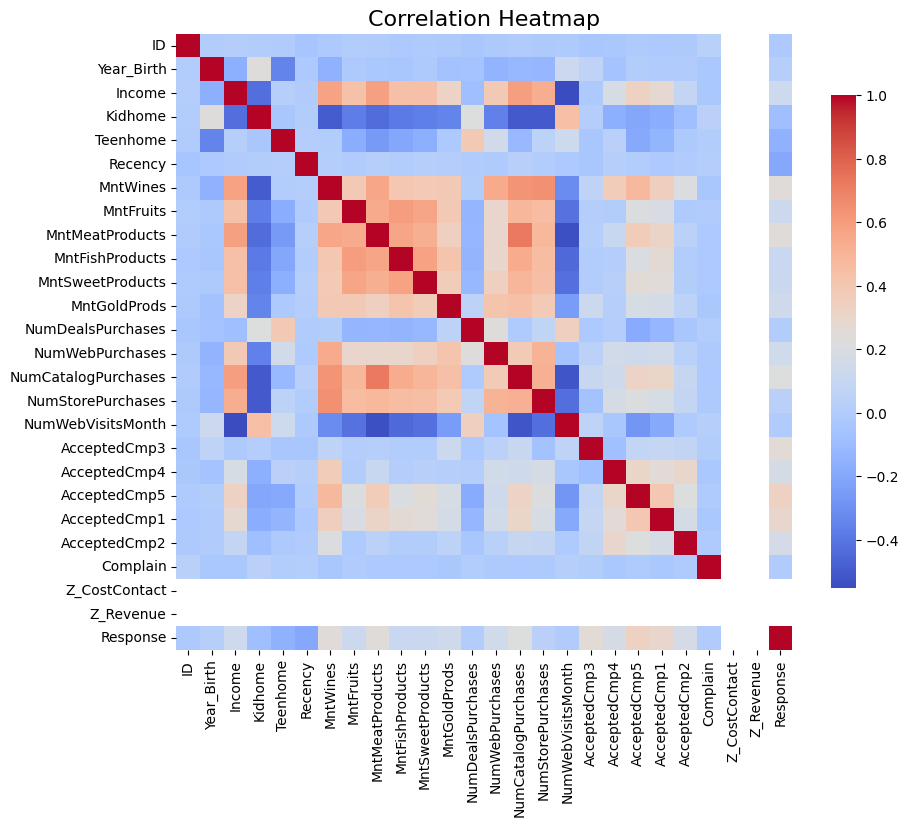

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("marketing_campaign.csv",sep='\t',header=(0))
print(df.info())
print(df.nunique())
print(df[['Education']].value_counts())
print(df[['Marital_Status']].value_counts())

matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## Data preperation and feature engineering

In [ ]:
df = df.dropna() # income contains nulls

#Feature engineering
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Days_Since_Joining'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days
df['Year_Enrolled'] = df['Dt_Customer'].dt.year
df['Customer_Age'] = (pd.to_datetime('today').year - df['Year_Birth'])
df['Total_kids'] = df[['Kidhome', 'Teenhome']].sum(axis=1)

# Aggegrating similar columns
df['Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Number_of_purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
df = df.drop(['Dt_Customer', 'Z_Revenue', 'Z_CostContact', 'ID', 'Year_Birth'], axis=1)


print(df.info())

## Cleaning messy data

In [ ]:
print(df[['Education']].value_counts())
print(df[['Marital_Status']].value_counts())

df['Education'] = df['Education'].replace(
    {'Graduation': 'Graduation',
     'PhD': 'Postgraduate',
     'Master': 'Postgraduate',
     '2n Cycle': 'Postgraduate',
     'Basic': 'Other'})

print(df[['Education']].value_counts())


df = df[~df['Marital_Status'].isin(['Absurd', 'YOLO'])]

df['Marital_Status'] = df['Marital_Status'].replace(
    {'Married': 'Together',
     'Together': 'Together',
     'Single': 'Single',
     'Divorced': 'Single',
     'Widow': 'Single',
     'Alone': 'Single'}
)

print(df[['Marital_Status']].value_counts())

df = pd.get_dummies(df, columns=['Education', 'Marital_Status']).astype(int)
print(df.head(2))
print(df.info())

## Finding and creating the optimal number of clusters

In [ ]:
features = df

scaler = StandardScaler()
features = scaler.fit_transform(features)

#Determining the optimal number of clusters
k_values = range(1, 11)

inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)
    
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Based on the elbow curve the optimal number of clusters is likely between 2 and 4.
# Using the silhouette score a more precise optimal amount of clusters can be determined

k_values = range(2, 11)

silhouette_scores = []

# Run KMeans and compute the silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    score = silhouette_score(features, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.grid(True)
plt.show()

# The silhouette score is the highest with 2 clusters, but based on the elbow line 3 is probably a better balance between distinction and representation.

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features) # Fitting the clusters on normalized data

df['Cluster'] = clusters # Applying the clusters on unnormalized data
print(df['Cluster'].value_counts())
cluster_profiles = df.groupby('Cluster').mean()

## Cluster overview

In [ ]:
# Drop columns with few unique values for scatterplot visual
x = df.drop(columns=df.columns[(df.nunique() < 4) & (df.columns != 'Cluster')])

sns.pairplot(x, hue='Cluster', palette='Set2', diag_kind='kde')

plt.show()

## General Cluster Characteristics

In [ ]:
print(df.columns)
""" General Features: 'Income', 'Kidhome', 'Teenhome', 'Total_kids' 'Education_Graduation', 'Education_Postgraduate', 'Education_Other', 'Customer_Age', 'Marital_Status_Single', 'Marital_Status_Together'  """
"""  Store related features: 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
'AcceptedCmp2', 'Complain', 'Response', 'Days_Since_Joining','Year_Enrolled', 'Spending', 'Number_of_Purchases' """

def cluster_profile(df):
    # Define the aggregations for other features (Income, Age, etc.)
    aggregations = {
        'Income': ['median', 'mean'],
        'Customer_Age': ['median', 'mean'],
        'Kidhome': 'mean',
        'Teenhome': 'mean',
        'Total_kids': 'median'
    }

    # Perform groupby and aggregate for non-percentage fields
    profile = df.groupby('Cluster').agg(aggregations)

    # Calculate total number of people in each cluster (for marital status)
    total_people = df.groupby('Cluster')[['Marital_Status_Single', 'Marital_Status_Together']].sum().sum(axis=1)

    # Calculate marital status percentages directly
    marital_status = df.groupby('Cluster')[['Marital_Status_Single', 'Marital_Status_Together']].sum().div(total_people, axis=0) * 100

    # Calculate total number of people in each cluster for education categories
    total_education = df.groupby('Cluster')[['Education_Graduation', 'Education_Postgraduate', 'Education_Other']].sum().sum(axis=1)

    # Calculate education percentages directly
    education_status = df.groupby('Cluster')[['Education_Graduation', 'Education_Postgraduate', 'Education_Other']].sum().div(total_education, axis=0) * 100

    # Combine the profile with the calculated percentages
    profile = pd.concat([profile, marital_status, education_status], axis=1)

    return profile

# Generate the cluster profile
cluster_summary = cluster_profile(df)

# Display the summary
print(cluster_summary)

In [ ]:
print(cluster_summary)